Need to apply NLP techniques in order to clean the data and train model in order to perform rating prediction  

LOGISTIC REGRESSION

In [1]:
#load required libraries ML: pandas,numpy and logistic regression reqiured. rest for deep learning

import pandas as pd
import numpy as np
from wordcloud import WordCloud

import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline




2021-08-09 11:32:51.317469: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-09 11:32:51.317507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#create a ffunction to load the text and labels from train and test set

In [3]:
def get_labels_and_texts(file):
    labels = []  #initialise empty lists
    texts = []
    for line in bz2.BZ2File(file):  
        x = line.decode("utf-8")     #extract 1 line from the file and store it in variable x. x now has line with labels and text
        labels.append(int(x[9]) - 1)  #extract label convert to integer append it to labels list
        texts.append(x[10:].strip())  #extract text  ""
    return np.array(labels), texts    #convert labels to numpy array and 

#call function
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2') #extract label and text from training data set
test_labels, test_texts = get_labels_and_texts('test.ft.txt.bz2')    #extract labels and text from test data set



In [4]:
#EXAMPLE SEE FIRST LABEL
train_labels[0]

1

In [5]:
# 1 means positive 0 means negative review lets see what actually the review was
train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [6]:
#as you can see the review was indeed positive
#the files contain train and test data set .they have 50,000 reviews
#extract only first 500 0f the reviews and perform logistic regression


In [7]:
train_labels=train_labels[0:500]

In [8]:
train_texts=train_texts[0:500]

In [9]:
df = pd.DataFrame({"labels": train_labels[0:500], "reviews": train_texts[0:500]})
df.head(5)

,labels,reviews
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


In [10]:
df = pd.DataFrame({"labels": test_labels[0:500], "reviews": test_texts[0:500]})
df.head(10)

,labels,reviews
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...
5,0,DVD Player crapped out after one year: I also ...
6,0,"Incorrect Disc: I love the style of this, but ..."
7,0,DVD menu select problems: I cannot scroll thro...
8,1,Unique Weird Orientalia from the 1930's: Exoti...
9,0,"Not an ""ultimate guide"": Firstly,I enjoyed the..."


In [11]:
#text pre-processing
#convert capital to small letter. remove special charachters like .,!^_^ etc.

In [12]:
import re  # re= regular expressions
NON_ALPHANUM = re.compile(r'[\W]')          # extract capital letters and charachters that are not alphanumeric
NON_ASCII = re.compile(r'[^a-z0-1\s]')      # similarly create regular expression method to extract small letters a-z and numbers 0-1 and some punctuation marks are stored in non ascii var
def normalize_texts(texts):                 #create method
    normalized_texts = []                   # initialise empty list
    for text in texts:                      #for each review/text do the following
        lower = text.lower()                 # covert entire review to lower case
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)  #substitute non alphanumeric char with a space
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation) # substitute non ascii charachters with blank or space
        normalized_texts.append(no_non_ascii) # append this preprocessed or review without non_ascii charachters to the list normalised texts
    return normalized_texts                    # return this normalised review (without capital and special char)
 
#call method on train_texts and test_texts
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)       # now train_texta and test_tests have reviews(without capital and special char)


In [13]:
train_texts[0]

'stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    '

In [14]:
#now you can see the difference between ouput[7] and output[11]. capital letters are made into small letters and special charachters are substituted by space

In [15]:
# now to build themodel and predict the test set what to do?
#convert this text to numeric charachters. computer/NLP/Sentiment analysis model cant understand textual data so 
# we will convert the textual data to some numeric form called count vector
# we use countvectorizer method

In [16]:
from sklearn.feature_extraction.text import CountVectorizer      #import countvectorizer

cv = CountVectorizer(binary=True)     # the entire text is only converted to 0 or 1 (binary) this is stored in the object called cv
cv.fit(train_texts)                   # fit this count vectoriser to the training text
X = cv.transform(train_texts)          # transform training set. store it in X
X_test = cv.transform(test_texts)     # transform testing set. store it in X_test

#eg label=stuning occurs 1 time in the output 11(review 0)
#   label=it count=5 this how count vectoriser works

In [17]:
#X_test will look like this:
X_test

<400000x5778 sparse matrix of type '<class 'numpy.int64'>'
	with 18647020 stored elements in Compressed Sparse Row format>

In [29]:
#now build the logistic regression model on top of this

from sklearn.linear_model import LogisticRegression    #import Logistic Regression
from sklearn.metrics import accuracy_score              # check its accuracy
from sklearn.model_selection import train_test_split    #divide data into training and testing set


#to divide the data into trainig and testing set: use train_test_split method. 
#parameters are training set
#independant variables are: X dependant variables are: train_labels and train_size=0.75 (i.e. 75% of data goes to training set and rest 25% goes to test set)

X_train, X_val, y_train, y_val = train_test_split(       
    X, train_labels, train_size = 0.75, random_state=6
)

#C ( here c is capital) value means: by how much do we want to regularise the model on to the data
#as C increases regularisation increases
# we are building the logistic regression model in this for loop

for c in [0.01, 0.05]:
    
    lr = LogisticRegression(C=c)                             #build logisticregression with c value 0.01 at first
    lr.fit(X_train, y_train)                                 #fit this logistic regression model on train set
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))    #check the accuracy on top of the validation set here
    

Accuracy for C=0.01: 0.832
Accuracy for C=0.05: 0.864


In [30]:
# observation: accuracy increases as regularisation(C value) increases
# when C value is 1(highest) the accuracy is highest on top of the validation data set
# so we take the value of C to be perfect

In [31]:
# since we have fit the model on top of the training set we are going to
# start predicting the values on top of the test set using lr.predict
#lets predict on the 29th review
lr.predict(X_test[29])

array([0])

In [32]:
test_labels[29]

0

In [33]:
# you can see that the actual/observed/expected value (ouput 16) = predicted value(ouput 15)
#so the model is working descently
#0 means negative 1 means positive
#let us see the actual review:

In [34]:
test_texts[29]

'three days of use and it broke  very disappointed in this product  it worked perfectly for exactly three days and could not be resuscitated  it was very inexpensive so i did not want to pay half again the price to ship it back for an exchange  so the company would do nothing when they sent me an inquiry as to product satisfaction '

In [35]:
# the above review is indeed negative as we have already predicted
# you can build this more by using:
# neural nw, cnn,rnn,decisiontree,randomforest,other classifiers:nybase etc on top of this.

Text(0.5, 1.0, 'Sentiment analysis')

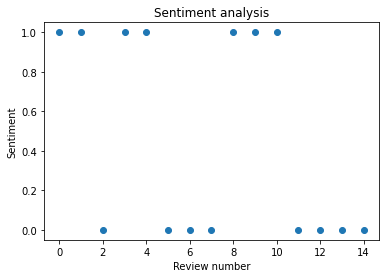

In [36]:
#scatter Graph for predicted class label(0 as negative sentiment 1 as positive sentiment)

reviewnum=list(range(0,15))
plt.scatter(reviewnum,lr.predict(X_test[0:15]))
plt.xlabel('Review number')
plt.ylabel('Sentiment')
plt.title('Sentiment analysis')

Text(0.5, 1.0, 'Sentiment analysis')

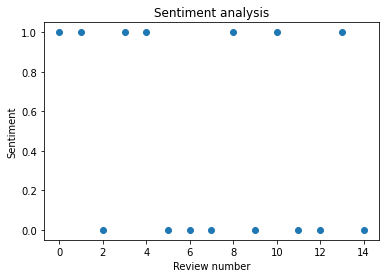

In [37]:
#scatter Graph for the actual class label(0 as negative sentiment 1 as positive sentiment)

reviewnum=list(range(15))
plt.scatter(reviewnum,test_labels[0:15])
plt.xlabel('Review number')
plt.ylabel('Sentiment')
plt.title('Sentiment analysis')

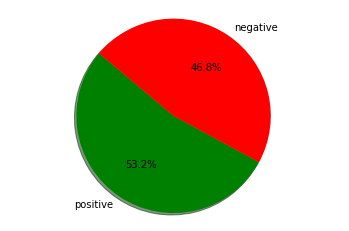

In [38]:
#Pie chart for the predicted sentiment


labels = 'positive', 'negative'

predictedvalue=lr.predict(X_test[0:500])
positive=0;
negative=0;
for i in predictedvalue:
    if i==1:
        positive+=1
    else:
        negative+=1

sizes = [positive, negative]
colors = ['green', 'red']
explode = (0, 0)  # explode no slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

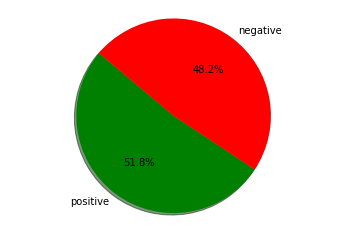

In [39]:
#Pie chart for the actual sentiment


labels = 'positive', 'negative'

actualvalue=test_labels[0:500]
positive=0;
negative=0;
for i in actualvalue:
    if i==1:
        positive+=1
    else:
        negative+=1

sizes = [positive, negative]
colors = ['green', 'red']
explode = (0, 0)  # explode no slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d611ce83-46e4-4a42-b601-819324222ef9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>